In [44]:
import os
import json
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    confusion_matrix, accuracy_score, f1_score, roc_curve, precision_recall_curve
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from joblib import dump
import matplotlib.pyplot as plt

RANDOM_STATE = 42

# Label Mappings and Utility Functions


In [45]:
def map_labels(series):
    """Maps disposition labels to binary classes."""
    mapping = {"CP": 1, "KP": 1, "FP": 0, "FA": 0, "PC": np.nan, "APC": np.nan}
    mapped = series.astype(str).str.upper().map(mapping)
    return mapped.dropna()

def engineer_features(df):
    """
    Engineers new features for the TESS dataset.
    This function now includes an additional domain-specific feature.
    """
    df = df.copy()

    # --- Start of your pre-existing code ---
    for col in df.columns:
        if col.endswith("err1") and col[:-4] + "err2" in df.columns and col[:-4] in df.columns:
            base = col[:-4]
            val = df[base].replace(0, np.nan).abs()
            df[f"relative_uncertainty_{base}"] = (
                df[base + 'err1'].abs() + df[base + 'err2'].abs()
            ) / (2 * val)

        if col.endswith("lim"):
            base = col[:-3]
            df[f"is_limited_{base}"] = (df[col].fillna(0) != 0).astype(int)

    def safe_div(a, b):
        with np.errstate(divide='ignore', invalid='ignore'):
            r = a / b
            return r.replace([np.inf, -np.inf], np.nan)

    derived_features = {
        'transit_snr': ('pl_trandep', lambda df: safe_div(df['pl_trandep'], np.sqrt(df['pl_trandurh']))),
        'planet_star_radius_ratio': ('pl_rade', lambda df: safe_div(df['pl_rade'], df['st_rad'])),
        'flux_temp_ratio': ('pl_insol', lambda df: safe_div(df['pl_insol'], df['st_teff'])),
        'period_over_duration': ('pl_orbper', lambda df: safe_div(df['pl_orbper'], df['pl_trandurh'])),
        'depth_over_tmag': ('pl_trandep', lambda df: safe_div(df['pl_trandep'], df['st_tmag'])),

        # --- Appended Code:
        'transit_shape_proxy': ('pl_trandurh', lambda df: safe_div(df['pl_trandurh'], df['pl_orbper']))
    }

    for name, (ref, func) in derived_features.items():
        try:
            if ref in df.columns:
                df[name] = func(df)
        except Exception:
            pass

    return df

# ML pipeline

In [46]:
def build_pipeline():
    return ImbPipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('rf', RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])

# Visualization Function

In [47]:
def plot_results(y_test, y_prob, feature_importances, show_inline=True):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.3f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.tight_layout()
    if show_inline:
        plt.show()
    plt.close()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure()
    plt.plot(recall, precision, label=f"PR Curve (AUC = {average_precision_score(y_test, y_prob):.3f})")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.tight_layout()
    if show_inline:
        plt.show()
    plt.close()

    # Feature Importances
    plt.figure(figsize=(8, 6))
    feature_importances.head(20).sort_values().plot(kind='barh')
    plt.title('Top 20 Feature Importances')
    plt.xlabel('Importance')
    plt.tight_layout()
    if show_inline:
        plt.show()
    plt.close()

# Objective Function for Optuna

In [48]:
def objective(trial, X_train, y_train):
    n_estimators = trial.suggest_int('rf__n_estimators', 100, 800)
    max_depth = trial.suggest_categorical('rf__max_depth', [None, 10, 20, 30, 40])
    min_samples_split = trial.suggest_int('rf__min_samples_split', 2, 15)
    max_features = trial.suggest_categorical('rf__max_features', ['sqrt', 'log2'])

    pipeline = build_pipeline()
    pipeline.set_params(
        rf__n_estimators=n_estimators,
        rf__max_depth=max_depth,
        rf__min_samples_split=min_samples_split,
        rf__max_features=max_features
    )

    scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        scoring='average_precision', n_jobs=-1
    )

    return np.mean(scores)

# Main Function

[INFO] Loading dataset from: tess.csv
[INFO] Engineering features...
Index(['ra', 'dec', 'st_pmra', 'st_pmdec', 'pl_tranmid', 'pl_orbper',
       'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag',
       'st_dist', 'st_teff', 'st_logg', 'st_rad',
       'relative_uncertainty_st_pmra', 'is_limited_st_pmra',
       'relative_uncertainty_st_pmdec', 'is_limited_st_pmdec',
       'relative_uncertainty_pl_tranmid', 'is_limited_pl_tranmid',
       'relative_uncertainty_pl_orbper', 'is_limited_pl_orbper',
       'relative_uncertainty_pl_trandurh', 'is_limited_pl_trandurh',
       'relative_uncertainty_pl_trandep', 'is_limited_pl_trandep',
       'relative_uncertainty_pl_rade', 'is_limited_pl_rade',
       'relative_uncertainty_pl_insol', 'is_limited_pl_insol',
       'relative_uncertainty_pl_eqt', 'is_limited_pl_eqt',
       'relative_uncertainty_st_tmag', 'is_limited_st_tmag',
       'relative_uncertainty_st_dist', 'is_limited_st_dist',
       'relative_uncertainty_st_te

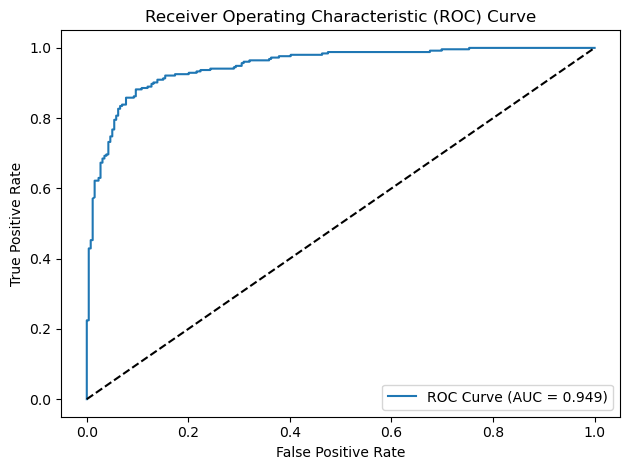

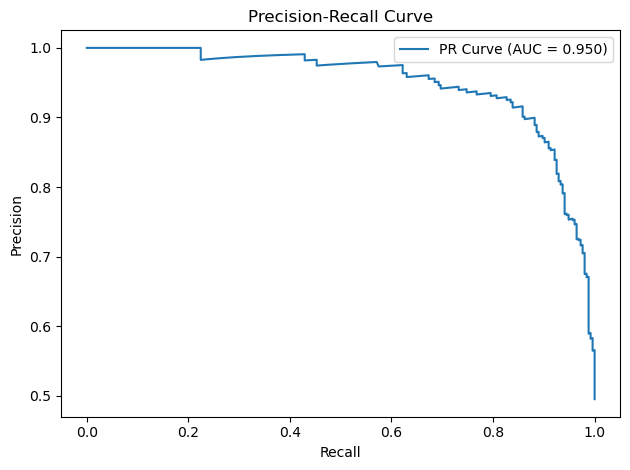

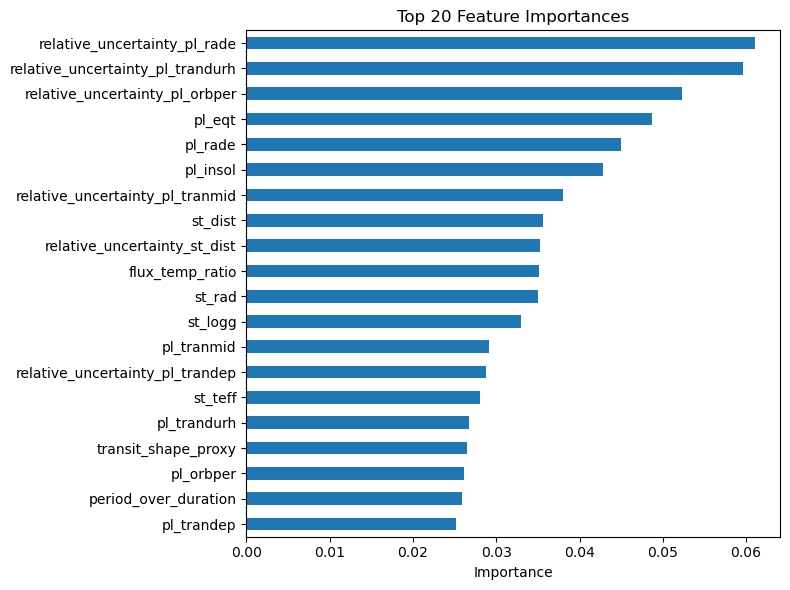

In [49]:
def main(csv_path="tess.csv", n_trials=70):
    print(f"[INFO] Loading dataset from: {csv_path}")
    df = pd.read_csv(csv_path)

    if 'tfopwg_disp' not in df.columns:
        raise ValueError("Expected 'tfopwg_disp' column for classification target.")

    y = map_labels(df['tfopwg_disp'])
    df = df.loc[y.index]

    print("[INFO] Engineering features...")
    X = df.drop(columns=['tfopwg_disp','toi','tid','rastr','decstr','toi_created','rowupdate'], errors='ignore')
    X = engineer_features(X)
    X=X.drop(columns=['st_pmraerr1',
    'st_pmraerr2',
    'st_pmdecerr1',
    'st_pmdecerr2',
    'pl_tranmiderr1',
    'pl_tranmiderr2',
    'pl_orbpererr1',
    'pl_orbpererr2',
    'pl_trandurherr1',
    'pl_trandurherr2',
    'pl_trandeperr1',
    'pl_trandeperr2',
    'pl_radeerr1',
    'pl_radeerr2',
    'pl_insolerr1',
    'pl_insolerr2',
    'pl_eqterr1',
    'pl_eqterr2',
    'st_tmagerr1',
    'st_tmagerr2',
    'st_disterr1',
    'st_disterr2',
    'st_tefferr1',
    'st_tefferr2',
    'st_loggerr1',
    'st_loggerr2',
    'st_raderr1',
    'st_raderr2',
    'st_pmralim',
    'st_pmdeclim',
    'pl_tranmidlim',
    'pl_orbperlim',
    'pl_trandurhlim',
    'pl_trandeplim',
    'pl_radelim',
    'pl_insollim',
    'pl_eqtlim',
    'st_tmaglim',
    'st_distlim',
    'st_tefflim',
    'st_logglim',
    'st_radlim'])
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X = X[numeric_cols]
    print(X.columns)
    X = X.dropna(axis=1, how='all')

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    print("[INFO] Starting Bayesian Optimization with Optuna... (please wait)")

    # Disable Optuna logs to hide trial-by-trial output
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=n_trials, show_progress_bar=False)

    print("\n==================== OPTIMIZATION COMPLETE ====================")
    print(f"[INFO] Best Hyperparameters found: {study.best_params}\n")

    best_params = study.best_params
    best_pipeline = build_pipeline()
    best_pipeline.set_params(**best_params)

    best_pipeline.fit(X_train, y_train)

    y_pred = best_pipeline.predict(X_test)
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]

    metrics = {
        'roc_auc': roc_auc_score(y_test, y_prob),
        'pr_auc': average_precision_score(y_test, y_prob),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
    }

    # Save only the trained pipeline in the current working directory
    model_path = os.path.join(os.getcwd(), 'rf_pipeline_optuna.joblib')
    dump(best_pipeline, model_path)

    print("==================== MODEL PERFORMANCE ====================")
    print(f"ROC-AUC: {metrics['roc_auc']:.3f}")
    print(f"PR-AUC: {metrics['pr_auc']:.3f}")
    print(f"Accuracy: {metrics['accuracy']:.3f}")
    print(f"F1 Score: {metrics['f1_score']:.3f}\n")

    print("Confusion Matrix:")
    print(np.array(metrics['confusion_matrix']))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print(f"[INFO] Model training complete. Model saved to: {model_path}")

    feature_importances = pd.Series(
        best_pipeline.named_steps['rf'].feature_importances_, index=X.columns
    ).sort_values(ascending=False)

    plot_results(y_test, y_prob, feature_importances, show_inline=True)

if __name__ == "__main__":
    main()